In [6]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import seaborn as sns
from pathlib import Path
import warnings
warnings.filterwarnings('ignore')

# basic setup and read the data
cmap = cm.get_cmap('Pastel1')
PROJECT_DIR = Path().resolve()
data = pd.read_pickle(PROJECT_DIR / "processed_data/bonds-analyzed.pkl")

# in case, there is a problem...
copy = data.copy()

print(f"""
Data shape: {data.shape}
Data description: {data.info()}
""")

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10205 entries, 0 to 10204
Data columns (total 52 columns):
 #   Column                    Non-Null Count  Dtype         
---  ------                    --------------  -----         
 0   Issuer                    10205 non-null  object        
 1   Ticker                    10205 non-null  object        
 2   Amt Out                   10205 non-null  float64       
 3   Cpn                       10204 non-null  object        
 4   Maturity                  10205 non-null  datetime64[ns]
 5   YTM - Ask                 10205 non-null  object        
 6   YTM - Bid                 10205 non-null  object        
 7   Series                    4199 non-null   object        
 8   BBG Composite             6509 non-null   object        
 9   Mty Type                  10205 non-null  object        
 10  Currency                  10205 non-null  object        
 11  Country                   10187 non-null  object        
 12  Name_10y          

+ exclude CALLABLE, PUTABLE
+ exclude risky countries
+ exclude credit risk
+ exclude liquidity risk

In [9]:
data = data[~data['Mty Type'].isin(['CALLABLE', 'PUTABLE', 'CALL/SINK', 'CALL/PUT'])]

In [41]:
data = data[~data['Country'].isin(['Lebanon', 'Argentina', 'Armenia', 'Russia', 'Israel', 'Ukraine', 'Belarus', 'Venezuela'])]

In [27]:
data.Issuer.value_counts().head(10)

Issuer
Federal Farm Credit Banks Funding Corp     800
Federal Home Loan Banks                    774
United States Treasury Note/Bond           335
Federal Home Loan Bank Discount Notes      170
State of North Rhine-Westphalia Germany    120
Italy Buoni Poliennali Del Tesoro          120
United States Treasury Strip Principal     114
BNG Bank NV                                 79
Caisse Francaise de Financement Local       74
Federal Farm Credit Discount Notes          72
Name: count, dtype: int64

In [28]:
fedfarm     = data[data["Issuer"] == "Federal Farm Credit Banks Funding Corp"]
fedhome     = data[data["Issuer"] == "Federal Home Loan Banks"]
us_treasury = data[data["Issuer"] == "United States Treasury Note/Bond"]
fedhomedisc = data[data["Issuer"] == "Federal Home Loan Bank Discount Notes"]
nrw         = data[data["Issuer"] == "State of North Rhine-Westphalia Germany"]
italy       = data[data["Issuer"] == "Italy Buoni Poliennali Del Tesoro"]
us_strips   = data[data["Issuer"] == "United States Treasury Strip Principal"]
bng         = data[data["Issuer"] == "BNG Bank NV"]
france      = data[data["Issuer"] == "Caisse Francaise de Financement Local"]
fedfarmdisc = data[data["Issuer"] == "Federal Farm Credit Discount Notes"]

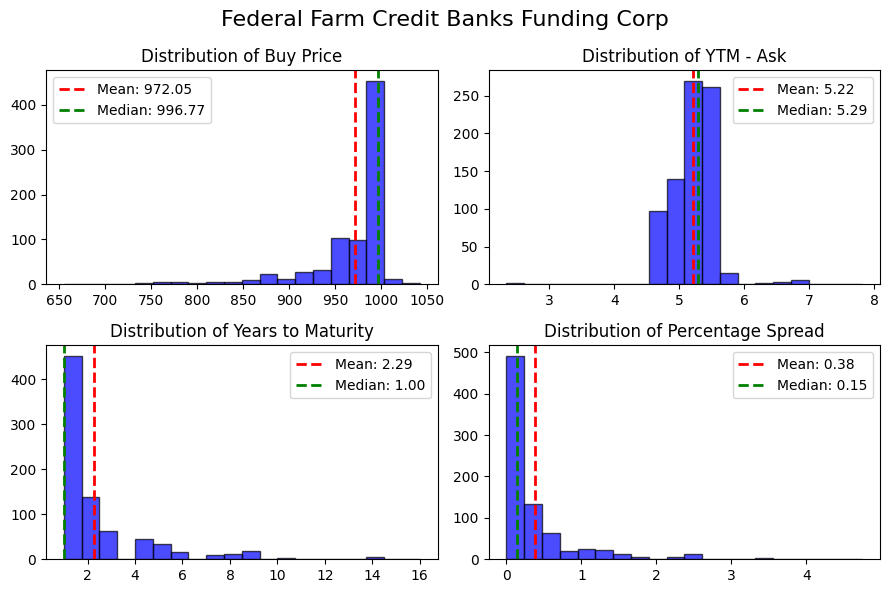

In [35]:
# Create a 2x2 subplot grid
fig, axes = plt.subplots(2, 2, figsize=(9, 6))

# Define the columns and titles for each subplot
columns = ["Buy Price", "YTM - Ask", "Years to Maturity", "Percentage Spread"]
titles = ["Distribution of Buy Price", "Distribution of YTM - Ask",
          "Distribution of Years to Maturity", "Distribution of Percentage Spread"]

# Loop through the subplots and create histograms
for i in range(4):
    ax = axes[i // 2, i % 2]
    col = columns[i]
    title = titles[i]
    
    # Plot the histogram
    ax.hist(fedfarm[col], bins=20, alpha=0.7, color='b', edgecolor='black')
    
    # Calculate and plot the mean and median as vertical lines
    mean_val = fedfarm[col].mean()
    median_val = fedfarm[col].median()
    ax.axvline(mean_val, color='r', linestyle='dashed', linewidth=2, label=f"Mean: {mean_val:.2f}")
    ax.axvline(median_val, color='g', linestyle='dashed', linewidth=2, label=f"Median: {median_val:.2f}")
    
    # Set subplot title and legend
    ax.set_title(title)
    ax.legend(loc='best')

plt.suptitle("Federal Farm Credit Banks Funding Corp", fontsize=16)

# Adjust subplot layout
plt.tight_layout()

plt.savefig("figures/fedfarm.png")

# Display the plot
plt.show()

### Liquidity and Spreads

<Axes: >

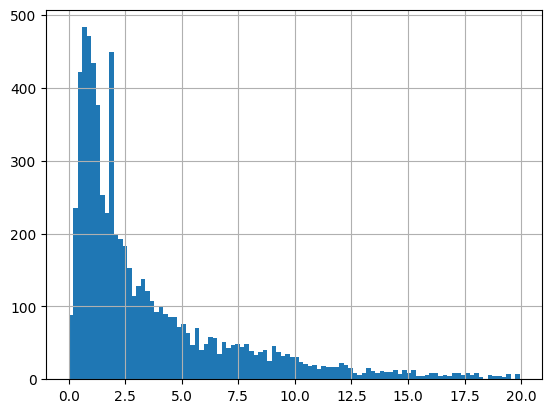

In [15]:
data[data['Buy-Sell Spread'] < 20]['Buy-Sell Spread'].hist(bins=100)

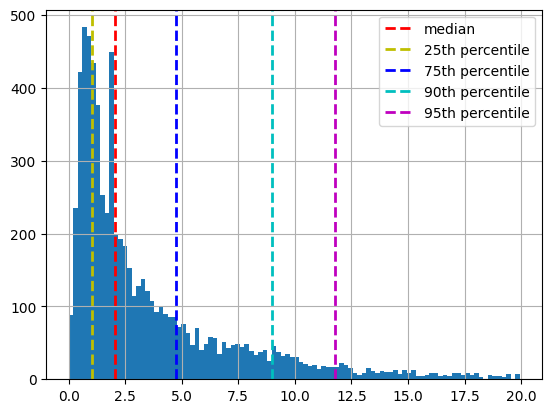

In [18]:
# Filter the data and calculate the median
filtered_data = data[data['Buy-Sell Spread'] < 20]
median_value = filtered_data['Buy-Sell Spread'].median()

# Calculate the percentiles
percentiles = [filtered_data['Buy-Sell Spread'].quantile(i) for i in [0.25, 0.75, 0.90, 0.95]]

# Create the histogram
filtered_data['Buy-Sell Spread'].hist(bins=100)

# Draw a vertical line at the median
plt.axvline(median_value, color='r', linestyle='dashed', linewidth=2, label='median')

# Draw vertical lines at the percentiles
colors = ['y', 'b', 'c', 'm']
labels = ['25th percentile', '75th percentile', '90th percentile', '95th percentile']
for percentile, color, label in zip(percentiles, colors, labels):
    plt.axvline(percentile, color=color, linestyle='dashed', linewidth=2, label=label)

# Add a legend
plt.legend()

# Show the plot
plt.show()

In [36]:
issuer_with_highest_avg_ytm_ask = data.groupby('Issuer')['YTM - Ask'].mean().idxmax()
issuer_with_highest_avg_ytm_ask

'Development Bank of the Republic of Belarus JSC'

In [49]:
unique_issuers = data[data['BBG Composite'] == 'BBB-']['Issuer'].unique()
print(unique_issuers)

['Hungary Government International Bond'
 'Panama Government International Bond'
 'Mexico Government International Bond' 'Panama Bonos del Tesoro'
 'Panama Notas del Tesoro' 'Export-Import Bank of India'
 'Romanian Government International Bond'
 'Kazakhstan Government International Bond'
 'Corp Financiera de Desarrollo SA' 'Autonomous Community of Catalonia'
 'Hellenic Republic Government International Bond'
 'Istituto per il Credito Sportivo'
 'Autonomous Community of Andalusia Spain' 'Region of Campania Italy'
 'Autonomous Region of the Azores' 'Cassa Depositi e Prestiti SpA']


In [61]:
macar = data[data["Issuer"]=='Hungary Government International Bond'][['Years to Maturity', 'YTM - Ask', 'Buy Price', 'Percentage Spread', 'BBG Composite', 'Macaulay Duration (Buy)', 'Modified Duration (Buy)']]

In [62]:
macar.head()

,Years to Maturity,YTM - Ask,Buy Price,Percentage Spread,BBG Composite,Macaulay Duration (Buy),Modified Duration (Buy)
222,17,6.884729,1073.502,0.592640,BBB-,10.058,9.723
490,1,5.248303,1001.219,0.463835,BBB-,0.987,0.962
1290,4,6.079547,1001.593,0.516377,BBB-,3.608,3.502
1368,6,6.113339,957.177,0.821896,BBB-,5.203,5.049
1420,11,6.461002,925.162,0.705066,BBB-,8.276,8.017


In [54]:
data[data["Issuer"]=='Hungary Government International Bond'][['Years to Maturity', 'YTM - Ask', 'Buy Price', 'Percentage Spread']].describe()

,Years to Maturity,YTM - Ask,Buy Price,Percentage Spread
count,20.000000,20.000000,20.000000,20.000000
mean,10.050000,5.508143,872.698550,0.888752
std,8.647939,0.872009,157.394616,0.420815
min,1.000000,3.990854,504.472000,0.463835
25%,4.000000,4.851111,759.279000,0.608745
50%,8.000000,5.315609,937.282000,0.795198
75%,11.250000,6.251047,986.585000,1.023790
max,29.000000,6.903047,1073.502000,2.325798


In [48]:
grouped_data = data.groupby('BBG Composite')[['YTM - Ask', 'YTM - Bid', 'Buy Price', 'Sell Price', 'Years to Maturity', 'Percentage Spread']].mean()
grouped_data

,YTM - Ask,YTM - Bid,Buy Price,Sell Price,Years to Maturity,Percentage Spread
BBG Composite,,,,,,
A,3.859530,4.041043,873.290108,867.357946,8.666667,0.747373
A+,4.714530,4.80507,910.699711,907.146226,6.314465,0.434088
A-,3.948126,4.141079,939.028382,932.307836,7.136364,0.736040
AA,4.518203,4.612055,907.720057,904.116582,6.347518,0.435587
AA+,4.811737,5.00122,951.655774,947.963153,3.727170,0.406676
AA-,4.151668,4.248821,914.469745,910.863052,7.021077,0.414575
AAA,4.215221,4.272439,913.394124,911.212314,5.772414,0.263829
B,9.515114,10.126866,879.689333,868.444667,5.833333,1.294461
B+,7.418533,7.86311,925.123689,914.087934,8.393443,1.200523


In [43]:
# Convert 'YTM - Ask' to numeric, errors='coerce' will set non-numeric values to NaN
data['YTM - Ask'] = pd.to_numeric(data['YTM - Ask'], errors='coerce')
top_10_issuers = data.groupby('Issuer')['YTM - Ask'].mean().nlargest(25)
top_10_issuers

Issuer
Zambia Government International Bond                          83.383004
Sri Lanka Government International Bond                       73.903020
Ethiopia International Bond                                   55.807869
Ghana Government International Bond                           33.541044
Pakistan Government International Bond                        25.003841
Tunisian Republic                                             24.229909
Ecuador Government International Bond                         24.109778
Pakistan Water & Power Development Authority                  22.949810
Bolivian Government International Bond                        22.038885
Republic of Maldives Ministry of Finance and Treasury Bond    20.179783
Pakistan Global Sukuk Programme Co Ltd/The                    18.830627
El Salvador Government International Bond                     17.183134
Egypt Treasury Bills                                          16.835000
Egypt Government International Bond                      

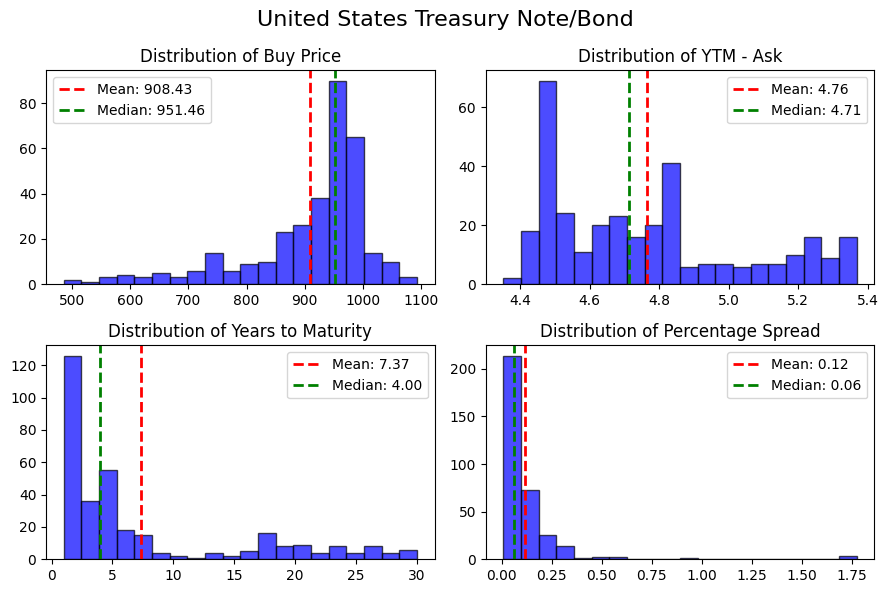

In [63]:
# Create a 2x2 subplot grid
fig, axes = plt.subplots(2, 2, figsize=(9, 6))

# Define the columns and titles for each subplot
columns = ["Buy Price", "YTM - Ask", "Years to Maturity", "Percentage Spread"]
titles = ["Distribution of Buy Price", "Distribution of YTM - Ask",
          "Distribution of Years to Maturity", "Distribution of Percentage Spread"]

# Loop through the subplots and create histograms
for i in range(4):
    ax = axes[i // 2, i % 2]
    col = columns[i]
    title = titles[i]
    
    # Plot the histogram
    ax.hist(us_treasury[col], bins=20, alpha=0.7, color='b', edgecolor='black')
    
    # Calculate and plot the mean and median as vertical lines
    mean_val = us_treasury[col].mean()
    median_val = us_treasury[col].median()
    ax.axvline(mean_val, color='r', linestyle='dashed', linewidth=2, label=f"Mean: {mean_val:.2f}")
    ax.axvline(median_val, color='g', linestyle='dashed', linewidth=2, label=f"Median: {median_val:.2f}")
    
    # Set subplot title and legend
    ax.set_title(title)
    ax.legend(loc='best')

plt.suptitle("United States Treasury Note/Bond", fontsize=16)

# Adjust subplot layout
plt.tight_layout()

plt.savefig("figures/us_treasury.png")

# Display the plot
plt.show()


In [64]:
data[(data['Country'] == 'United States') & (data['Years to Maturity'] == 2)][['YTM - Ask', 'Buy Price', 'Percentage Spread']].mean()

YTM - Ask              5.096969
Buy Price            975.311391
Percentage Spread      0.196979
dtype: float64

In [65]:
us2y = data[(data['Country'] == 'United States') & (data['Years to Maturity'] == 2)]

In [69]:
us2y_treasury = data[(data['Country'] == 'United States') & (data['Years to Maturity'] == 2) & (data['Issuer']=="United States Treasury Note/Bond")]

In [66]:
us2y.shape

(325, 52)

In [68]:
us2y.Issuer.value_counts()

Issuer
Federal Farm Credit Banks Funding Corp            138
Federal Home Loan Banks                           100
United States Treasury Note/Bond                   48
United States Treasury Strip Principal             11
Federal Agricultural Mortgage Corp                 10
Federal National Mortgage Association               7
United States Treasury Inflation Indexed Bonds      5
Federal Home Loan Mortgage Corp                     3
United States Treasury Floating Rate Note           2
Tennessee Valley Authority                          1
Name: count, dtype: int64

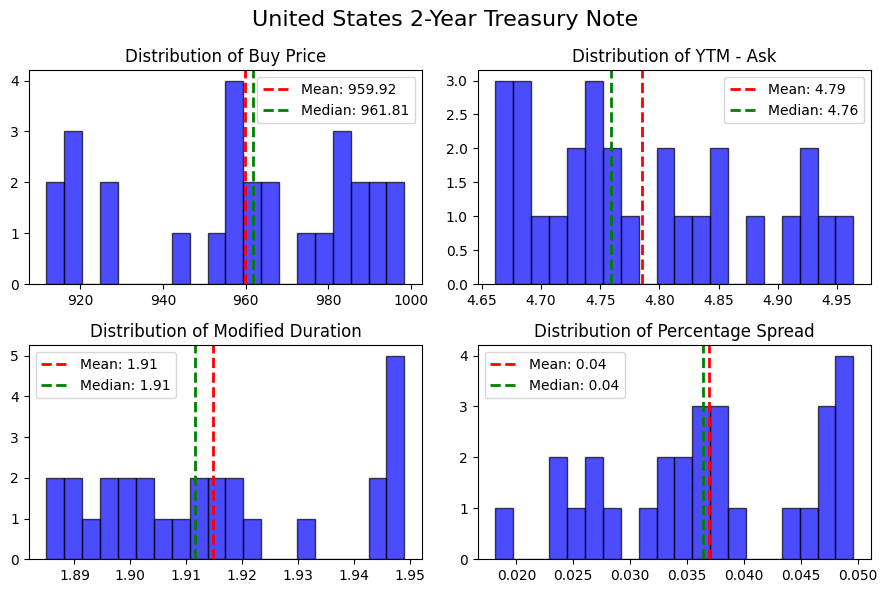

In [74]:
import matplotlib.pyplot as plt

# Create a 2x2 subplot grid
fig, axes = plt.subplots(2, 2, figsize=(9, 6))

# Define the columns and titles for each subplot
columns = ["Buy Price", "YTM - Ask", "Modified Duration (Buy)", "Percentage Spread"]
titles = ["Distribution of Buy Price", "Distribution of YTM - Ask",
          "Distribution of Modified Duration", "Distribution of Percentage Spread"]

# Loop through the subplots and create histograms
for i in range(4):
    ax = axes[i // 2, i % 2]
    col = columns[i]
    title = titles[i]
    
    # Plot the histogram
    ax.hist(us2y_treasury_subset[col], bins=20, alpha=0.7, color='b', edgecolor='black')
    
    # Calculate and plot the mean and median as vertical lines
    mean_val = us2y_treasury_subset[col].mean()
    median_val = us2y_treasury_subset[col].median()
    ax.axvline(mean_val, color='r', linestyle='dashed', linewidth=2, label=f"Mean: {mean_val:.2f}")
    ax.axvline(median_val, color='g', linestyle='dashed', linewidth=2, label=f"Median: {median_val:.2f}")
    
    # Set subplot title and legend
    ax.set_title(title)
    ax.legend(loc='best')

plt.suptitle("United States 2-Year Treasury Note", fontsize=16)

# Adjust subplot layout
plt.tight_layout()

# Save the plot as an image
plt.savefig("figures/us2y.png")

# Display the plot
plt.show()


In [71]:
us2y_treasury_subset = us2y_treasury[(us2y_treasury['Percentage Spread'] <= 0.05) & (us2y_treasury['Buy Price'] <= 1000)]

In [72]:
us2y_treasury_subset.shape

(28, 52)